In [1]:
! pip install -r requirements.txt --quiet

# load the data

In [1]:
import importlib
import Utils

# List all modules inside Utils that need reloading
modules_to_reload = ["Utils.load_data", "Utils.plot","Utils.training"]  # Add more if needed

# Reload each module
for module in modules_to_reload:
    importlib.reload(importlib.import_module(module))

# Import everything again
from Utils.load_data import *
from Utils.plot import *
from Utils.training import *
import gc 
gc.collect() #free RAM - garbage collector 
torch.cuda.empty_cache() 

In [2]:
path="data"
download_data_OD(path)
VOCDataset_train=VOCDataset_OD(path,year="2012",image_set='train',resize=(256,384))
VOCDataset_test=VOCDataset_OD(path,year="2012",image_set='val',resize=(256,384))

Data is already existed: data


In [3]:
train_loader = DataLoader(VOCDataset_train, batch_size=16, shuffle=True,collate_fn=voc_collate_fn,num_workers=64)
test_loader= DataLoader(VOCDataset_test, batch_size=16, shuffle=True,collate_fn=voc_collate_fn,num_workers=64)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load pre-trained Faster R-CNN with ResNet-50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Number of output classes (e.g., 20 classes + 1 for background)
num_classes = 21  # Pascal VOC has 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to("cuda" if torch.cuda.is_available() else "cpu")  # Move model to GPU if available


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torch.optim as optim

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
import gc 
gc.collect() #free RAM - garbage collector 
torch.cuda.empty_cache() 
train(model, train_loader, test_loader, optimizer, lr_scheduler, "cuda", num_epochs=10)

In [9]:
torch.save(model,"models/fasterrcnn_model.pth")


In [10]:
model=torch.load("models/fasterrcnn_model.pth")

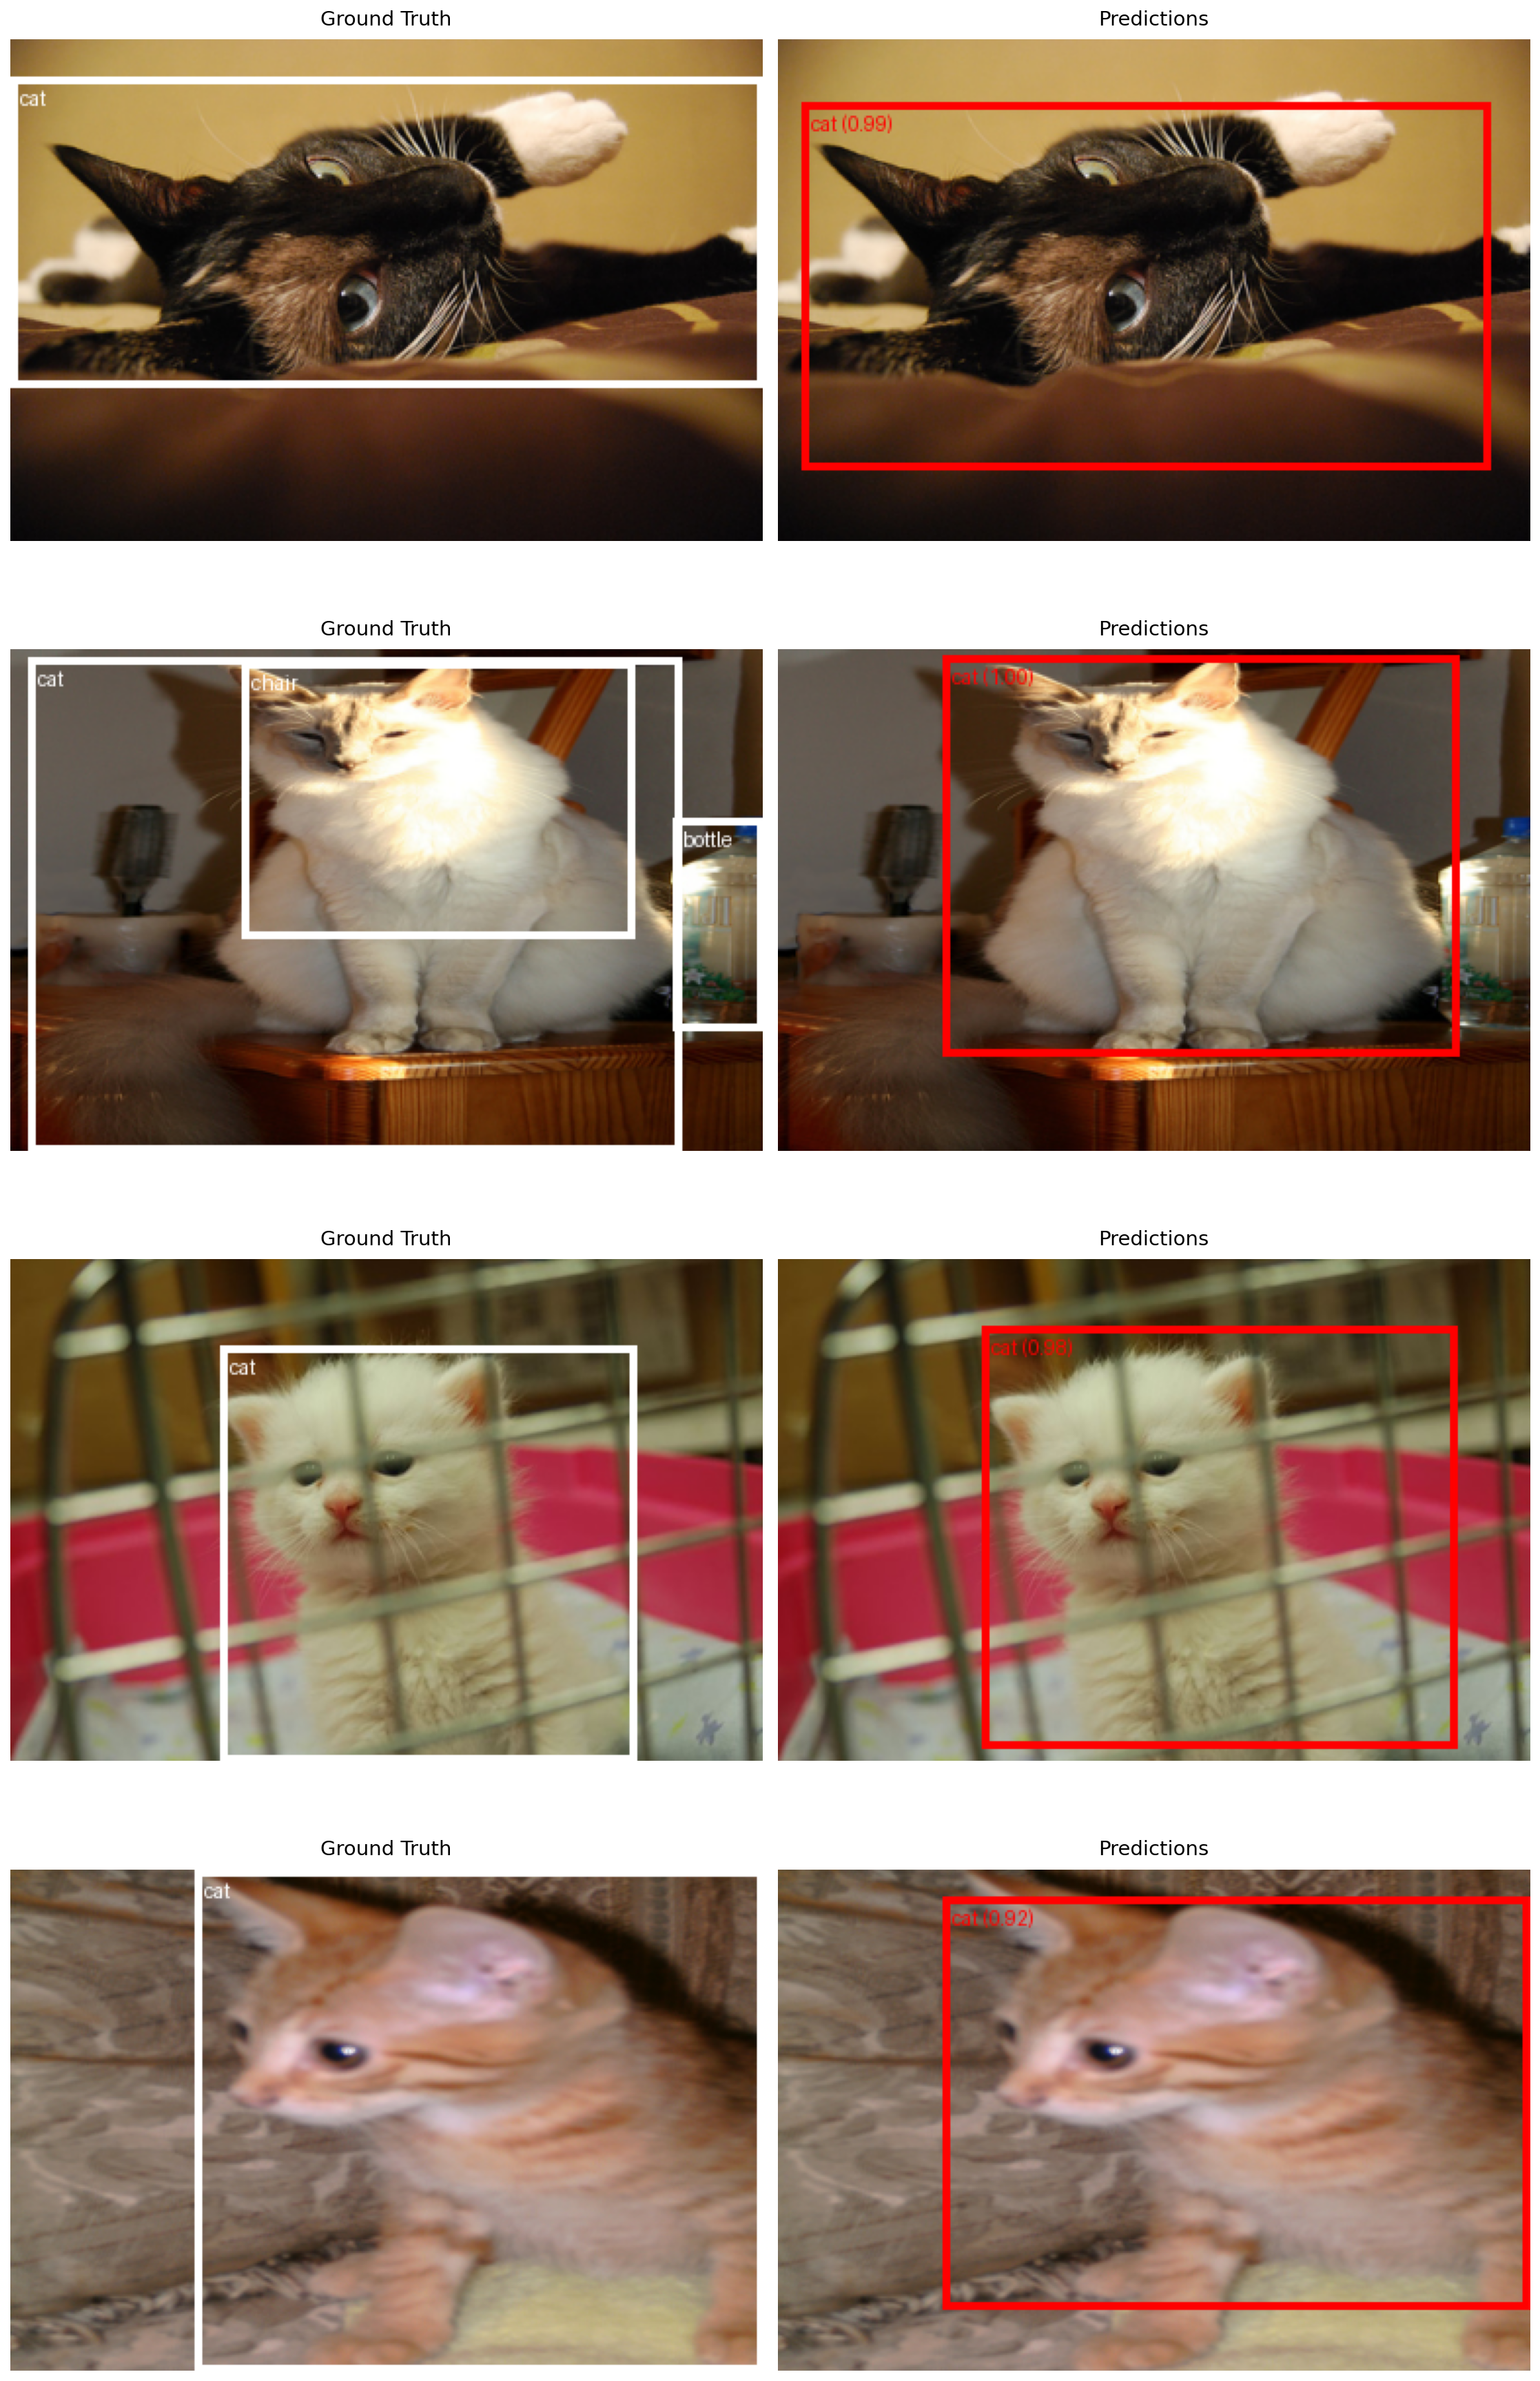

In [7]:
visualize_test_batch(model, test_loader, "cuda", iou_threshold=0.5, score_threshold=0.7)